In [1]:
pip install autogen diskcache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.4/860.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.2 MB/s eta 0:00:00


In [2]:
!pip install autogen-agentchat[lmm]~=0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.0 MB/s eta 0:00:00


In [3]:
# -*- coding: utf-8 -*-
"""
Complete Social Media Post Generator using Multi-Agent System
Built on top of the existing DALLE image generation agent

Requirements:
pip install autogen-agentchat[lmm]~=0.2
pip install diskcache
pip install openai
pip install matplotlib
pip install pillow
pip install termcolor
"""

import json
import os
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI
from PIL import Image
from termcolor import colored
from google.colab import userdata
import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, get_pil_image, gpt4v_formatter
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

# =============================================================================
# CONFIGURATION
# =============================================================================

# OpenAI Configuration
gpt_config = {
    "config_list": [{"model": "gpt-4-turbo-preview", "api_key": userdata.get('OPENAI_API_KEY')}],
    "timeout": 120,
    "temperature": 0.7,
}

gpt_vision_config = {
    "config_list": [{"model": "gpt-4o", "api_key": userdata.get('OPENAI_API_KEY')}],
    "timeout": 120,
    "temperature": 0.7,
}

dalle_config = {
    "config_list": [{"model": "dall-e-3", "api_key": userdata.get('OPENAI_API_KEY')}],
    "timeout": 120,
    "temperature": 0.7,
}

# Platform specifications for different social media platforms
PLATFORM_SPECS = {
    "instagram": {
        "image_sizes": {
            "square": (1080, 1080),
            "portrait": (1080, 1350),
            "story": (1080, 1920)
        },
        "caption_length": 2200,
        "hashtag_limit": 30,
        "optimal_hashtags": "8-15"
    },
    "linkedin": {
        "image_sizes": {
            "horizontal": (1200, 627),
            "square": (1080, 1080)
        },
        "caption_length": 3000,
        "hashtag_limit": 5,
        "optimal_hashtags": "3-5"
    },
    "twitter": {
        "image_sizes": {
            "horizontal": (1024, 512),
            "square": (1080, 1080)
        },
        "caption_length": 280,
        "hashtag_limit": 2,
        "optimal_hashtags": "1-2"
    },
    "facebook": {
        "image_sizes": {
            "horizontal": (1200, 630),
            "square": (1080, 1080)
        },
        "caption_length": 63206,
        "hashtag_limit": 30,
        "optimal_hashtags": "1-3"
    }
}

# =============================================================================
# HELPER FUNCTIONS (From original code + extensions)
# =============================================================================

def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    """
    Generate an image using OpenAI's DALL-E model and cache the result.
    """
    cache = Cache(".cache/")
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

def extract_img(agent: Agent) -> PIL.Image:
    """
    Extracts an image from the last message of an agent and converts it to a PIL image.
    """
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

def extract_field_from_response(response: str, field: str) -> str:
    """Extract a specific field from agent response"""
    pattern = f"{field}:\\s*(.*?)(?=\\n[A-Z_]+:|$)"
    match = re.search(pattern, response, re.DOTALL)
    return match.group(1).strip() if match else ""

def save_post_data(post_data: dict, filename: str = None):
    """Save generated post data to JSON file"""
    if filename is None:
        timestamp = int(time.time())
        filename = f"social_post_{timestamp}.json"

    with open(filename, 'w') as f:
        json.dump(post_data, f, indent=2)

    print(f"✅ Post data saved to {filename}")
    return filename

def display_post_summary(post_data: dict):
    """Display a formatted summary of the generated post"""
    print("\n" + "="*60)
    print("📱 SOCIAL MEDIA POST GENERATED!")
    print("="*60)

    print(f"\n🎯 TARGET AUDIENCE: {post_data.get('target_audience', 'N/A')}")
    print(f"📝 POST TYPE: {post_data.get('post_type', 'N/A')}")
    print(f"🎵 TONE: {post_data.get('tone', 'N/A')}")

    print(f"\n💬 MAIN CAPTION:")
    print(f"{post_data.get('caption', 'N/A')}")

    print(f"\n🏷️ HASHTAGS:")
    print(f"{post_data.get('hashtags', 'N/A')}")

    print(f"\n♿ ALT TEXT:")
    print(f"{post_data.get('alt_text', 'N/A')}")

    print(f"\n🖼️ IMAGE PROMPT:")
    print(f"{post_data.get('dalle_prompt', 'N/A')[:100]}...")

    print(f"\n📱 PLATFORM OPTIMIZATIONS:")
    for platform, content in post_data.get('platform_optimizations', {}).items():
        print(f"\n{platform.upper()}:")
        print(f"Caption: {content.get('caption', 'N/A')[:50]}...")

    print("\n" + "="*60)

# =============================================================================
# DALLE AGENT (From original code)
# =============================================================================

class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            api_key = llm_config["config_list"][0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = userdata.get('OPENAI_API_KEY')
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

# =============================================================================
# SOCIAL MEDIA SPECIALIST AGENTS
# =============================================================================

class ContentStrategistAgent(AssistantAgent):
    """Analyzes brand/topic and suggests post strategy"""

    def __init__(self, **kwargs):
        system_message = """You are a Content Strategist specializing in social media.
Your job is to analyze the user's request and create a strategic brief for social media posts.

For each request, provide:
1. TARGET_AUDIENCE: Who this post is for (be specific - demographics, interests, pain points)
2. POST_TYPE: (promotional, educational, entertainment, behind-the-scenes, user-generated, inspirational, news, etc.)
3. TONE: (professional, casual, humorous, inspirational, urgent, friendly, authoritative, etc.)
4. KEY_MESSAGE: Main point to communicate (one clear, compelling message)
5. VISUAL_STYLE: Style direction for the image (modern, vintage, minimalist, colorful, etc.)
6. PLATFORM_FOCUS: Which platforms this would work best on and why
7. ENGAGEMENT_STRATEGY: How to encourage interaction (questions, polls, CTAs, etc.)

Format your response EXACTLY like this:
TARGET_AUDIENCE: [detailed audience description]
POST_TYPE: [specific type]
TONE: [specific tone]
KEY_MESSAGE: [clear main message]
VISUAL_STYLE: [detailed visual direction]
PLATFORM_FOCUS: [platforms and reasoning]
ENGAGEMENT_STRATEGY: [specific tactics to drive engagement]
"""

        super().__init__(system_message=system_message, **kwargs)

class CopywriterAgent(AssistantAgent):
    """Creates captions, hashtags, and call-to-actions"""

    def __init__(self, **kwargs):
        system_message = """You are an expert Social Media Copywriter with proven success in creating viral content.
You understand psychology, persuasion, and what makes people stop scrolling and engage.

Based on the strategy brief, create compelling social media copy that:
- Hooks attention in the first few words
- Provides value or entertainment
- Includes a clear call-to-action
- Uses relevant hashtags strategically
- Is optimized for accessibility

Provide:
1. CAPTION: Engaging main caption (hook + value/story + CTA)
2. HASHTAGS: 15-20 strategic hashtags (mix of popular, niche, and branded)
3. ALT_TEXT: Detailed accessibility description for screen readers
4. HOOK_VARIATIONS: 3 alternative opening lines for A/B testing
5. CTA_OPTIONS: 3 different call-to-action options

Format your response EXACTLY like this:
CAPTION: [complete engaging caption]
HASHTAGS: #hashtag1 #hashtag2 #hashtag3 #hashtag4 #hashtag5 #hashtag6 #hashtag7 #hashtag8 #hashtag9 #hashtag10 #hashtag11 #hashtag12 #hashtag13 #hashtag14 #hashtag15
ALT_TEXT: [detailed image description for accessibility]
HOOK_VARIATIONS:
1. [alternative hook 1]
2. [alternative hook 2]
3. [alternative hook 3]
CTA_OPTIONS:
1. [CTA option 1]
2. [CTA option 2]
3. [CTA option 3]
"""

        super().__init__(system_message=system_message, **kwargs)

class VisualDirectorAgent(AssistantAgent):
    """Creates detailed prompts for DALLE based on strategy"""

    def __init__(self, **kwargs):
        system_message = """You are a Visual Director specializing in social media graphics that stop the scroll.
You understand visual psychology, color theory, composition, and what makes images perform well on social platforms.

Based on the content strategy and copy, create a detailed DALLE prompt that will generate an image optimized for social media engagement.

Consider:
- Eye-catching composition that works at small sizes
- Colors that stand out in social feeds
- Clear focal points and visual hierarchy
- Space for text overlays if needed
- Brand-appropriate aesthetic
- Platform-specific requirements
- Current design trends that drive engagement

Your prompt should be specific enough to generate a professional, scroll-stopping image.

Format your response EXACTLY like this:
DALLE_PROMPT: [detailed, specific image generation prompt of 200+ words]
STYLE_NOTES: [additional considerations for the visual approach]
COLOR_PSYCHOLOGY: [why these colors will work for this audience/platform]
COMPOSITION_RATIONALE: [why this composition will drive engagement]
"""

        super().__init__(system_message=system_message, **kwargs)

class PlatformOptimizerAgent(AssistantAgent):
    """Adapts content for different social media platforms"""

    def __init__(self, **kwargs):
        system_message = """You are a Platform Optimization Specialist who understands the unique characteristics, algorithms, and best practices for each social media platform.

For the given content, create optimized versions for major platforms, considering:
- Character limits and optimal lengths
- Hashtag strategies for each platform
- Visual specifications and aspect ratios
- Audience behavior and expectations
- Algorithm preferences
- Platform-specific features (Stories, Reels, LinkedIn articles, etc.)

Provide optimized versions for:

INSTAGRAM:
- Recommended size: Square (1080x1080) or Portrait (1080x1350)
- Caption: Engaging hook in first 125 characters, up to 2,200 total
- Hashtags: 8-15 strategic mix in caption or first comment
- Features: Consider Stories, Reels potential

LINKEDIN:
- Recommended size: Horizontal (1200x627) or Square (1080x1080)
- Caption: Professional tone, 150-300 words for best engagement
- Hashtags: 3-5 professional, industry-specific hashtags
- Features: Consider native video, document posts

TWITTER/X:
- Recommended size: 16:9 (1024x512) or Square (1080x1080)
- Caption: Under 280 characters, punchy and conversation-starting
- Hashtags: 1-2 maximum, integrated naturally
- Features: Consider threads for longer content

FACEBOOK:
- Recommended size: 1200x630 for links, 1080x1080 for posts
- Caption: 40-80 characters get best reach, but can be longer for engagement
- Hashtags: 1-3 hashtags, less critical than other platforms
- Features: Consider Facebook Groups, Events

Format each platform clearly with specific recommendations.
"""

        super().__init__(system_message=system_message, **kwargs)

class SocialMediaAnalyzerAgent(AssistantAgent):
    """Analyzes and predicts post performance"""

    def __init__(self, **kwargs):
        system_message = """You are a Social Media Analytics Expert who can predict post performance and provide optimization recommendations.

Analyze the complete post package (strategy, copy, visual direction, platform optimizations) and provide:

1. ENGAGEMENT_PREDICTION: Likely performance on each platform (high/medium/low) with reasoning
2. OPTIMIZATION_SUGGESTIONS: Specific improvements to increase engagement
3. TIMING_RECOMMENDATIONS: Best posting times for target audience
4. HASHTAG_ANALYSIS: Assessment of hashtag strategy effectiveness
5. VIRAL_POTENTIAL: Elements that could make this content go viral
6. RISK_ASSESSMENT: Any potential issues or concerns
7. A/B_TEST_IDEAS: Specific variations to test for better performance

Provide actionable, data-driven insights based on current social media trends and best practices.

Format your response with clear sections for each analysis area.
"""

        super().__init__(system_message=system_message, **kwargs)

# =============================================================================
# MAIN SOCIAL MEDIA POST GENERATOR - FIXED VERSION
# =============================================================================

class SocialMediaPostGenerator(ConversableAgent):  # Changed from AssistantAgent
    """Main orchestrator that coordinates all specialist agents to create complete social media posts"""

    def __init__(self, llm_config: dict, dalle_config: dict, enable_analysis: bool = True, **kwargs):
        super().__init__(llm_config=llm_config, **kwargs)

        # Initialize all specialist agents
        self.strategist = ContentStrategistAgent(
            name="ContentStrategist",
            llm_config=llm_config,
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1
        )

        self.copywriter = CopywriterAgent(
            name="Copywriter",
            llm_config=llm_config,
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1
        )

        self.visual_director = VisualDirectorAgent(
            name="VisualDirector",
            llm_config=llm_config,
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1
        )

        self.platform_optimizer = PlatformOptimizerAgent(
            name="PlatformOptimizer",
            llm_config=llm_config,
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1
        )

        self.dalle = DALLEAgent(
            name="DALLE",
            llm_config=dalle_config,
            max_consecutive_auto_reply=1
        )

        if enable_analysis:
            self.analyzer = SocialMediaAnalyzerAgent(
                name="SocialMediaAnalyzer",
                llm_config=llm_config,
                human_input_mode="NEVER",
                max_consecutive_auto_reply=1
            )

        self.enable_analysis = enable_analysis
        self.post_data = {}

        # Register the reply function with proper signature
        self.register_reply([Agent, None], SocialMediaPostGenerator._generate_social_post)

    def _generate_social_post(self, messages: Optional[List[Dict]] = None, sender: Optional[Agent] = None, config: Optional[Any] = None):
        """Main workflow orchestrating all agents to generate complete social media post"""

        if messages is None:
            return False, "No messages provided"

        user_request = messages[-1]["content"]

        print("🚀 Starting Social Media Post Generation...")
        print(f"📝 Request: {user_request}")
        print("\n" + "="*60)

        try:
            # Step 1: Content Strategy
            print("🎯 STEP 1: Creating Content Strategy...")
            self.send(message=user_request, recipient=self.strategist, request_reply=True)
            strategy_response = self._oai_messages[self.strategist][-1]["content"]

            # Extract strategy components
            self.post_data['target_audience'] = extract_field_from_response(strategy_response, "TARGET_AUDIENCE")
            self.post_data['post_type'] = extract_field_from_response(strategy_response, "POST_TYPE")
            self.post_data['tone'] = extract_field_from_response(strategy_response, "TONE")
            self.post_data['key_message'] = extract_field_from_response(strategy_response, "KEY_MESSAGE")
            self.post_data['visual_style'] = extract_field_from_response(strategy_response, "VISUAL_STYLE")
            self.post_data['platform_focus'] = extract_field_from_response(strategy_response, "PLATFORM_FOCUS")
            self.post_data['engagement_strategy'] = extract_field_from_response(strategy_response, "ENGAGEMENT_STRATEGY")

            print(f"✅ Strategy Created - Target: {self.post_data['target_audience'][:50]}...")

            # Step 2: Copywriting
            print("\n✍️ STEP 2: Writing Engaging Copy...")
            copy_request = f"""Based on this strategy:
{strategy_response}

Original request: {user_request}

Create compelling social media copy that will engage the target audience and achieve the key message."""

            self.send(message=copy_request, recipient=self.copywriter, request_reply=True)
            copy_response = self._oai_messages[self.copywriter][-1]["content"]

            # Extract copy components
            self.post_data['caption'] = extract_field_from_response(copy_response, "CAPTION")
            self.post_data['hashtags'] = extract_field_from_response(copy_response, "HASHTAGS")
            self.post_data['alt_text'] = extract_field_from_response(copy_response, "ALT_TEXT")
            self.post_data['hook_variations'] = extract_field_from_response(copy_response, "HOOK_VARIATIONS")
            self.post_data['cta_options'] = extract_field_from_response(copy_response, "CTA_OPTIONS")

            print(f"✅ Copy Created - Caption length: {len(self.post_data['caption'])} chars")

            # Step 3: Visual Direction
            print("\n🎨 STEP 3: Creating Visual Direction...")
            visual_request = f"""Based on this strategy:
{strategy_response}

And this copy:
{copy_response}

Create a detailed, specific prompt for DALLE-3 to generate an engaging social media image."""

            self.send(message=visual_request, recipient=self.visual_director, request_reply=True)
            visual_response = self._oai_messages[self.visual_director][-1]["content"]

            # Extract visual components
            dalle_prompt = extract_field_from_response(visual_response, "DALLE_PROMPT")
            self.post_data['dalle_prompt'] = dalle_prompt
            self.post_data['style_notes'] = extract_field_from_response(visual_response, "STYLE_NOTES")
            self.post_data['color_psychology'] = extract_field_from_response(visual_response, "COLOR_PSYCHOLOGY")
            self.post_data['composition_rationale'] = extract_field_from_response(visual_response, "COMPOSITION_RATIONALE")

            print(f"✅ Visual Direction Created")

            # Step 4: Generate Image
            print("\n🖼️ STEP 4: Generating Image with DALLE...")
            print(f"Prompt: {dalle_prompt[:100]}...")

            self.send(message=dalle_prompt, recipient=self.dalle, request_reply=True)

            # Display generated image
            try:
                img = extract_img(self.dalle)
                plt.figure(figsize=(10, 10))
                plt.imshow(img)
                plt.axis("off")
                plt.title("Generated Social Media Image", fontsize=16, fontweight='bold')
                plt.tight_layout()
                plt.show()
                print("✅ Image Generated and Displayed")
                self.post_data['image_generated'] = True
            except Exception as e:
                print(f"❌ Error displaying image: {e}")
                self.post_data['image_generated'] = False

            # Step 5: Platform Optimization
            print("\n📱 STEP 5: Optimizing for Different Platforms...")
            platform_request = f"""Optimize this complete social media post for different platforms:

STRATEGY:
{strategy_response}

COPY:
{copy_response}

VISUAL DIRECTION:
{visual_response}

Provide platform-specific optimizations for Instagram, LinkedIn, Twitter, and Facebook."""

            self.send(message=platform_request, recipient=self.platform_optimizer, request_reply=True)
            platform_response = self._oai_messages[self.platform_optimizer][-1]["content"]

            self.post_data['platform_optimizations_raw'] = platform_response
            print("✅ Platform Optimizations Created")

            # Step 6: Performance Analysis (if enabled)
            if self.enable_analysis:
                print("\n📊 STEP 6: Analyzing Performance Potential...")
                analysis_request = f"""Analyze this complete social media post package for performance potential:

STRATEGY: {strategy_response}
COPY: {copy_response}
VISUAL: {visual_response}
PLATFORM OPTS: {platform_response}

Provide engagement predictions and optimization recommendations."""

                self.send(message=analysis_request, recipient=self.analyzer, request_reply=True)
                analysis_response = self._oai_messages[self.analyzer][-1]["content"]
                self.post_data['performance_analysis'] = analysis_response
                print("✅ Performance Analysis Complete")

            # Step 7: Compile and Save Results
            print("\n💾 STEP 7: Compiling Final Results...")

            # Save complete post data
            filename = save_post_data(self.post_data)

            # Display summary
            display_post_summary(self.post_data)

            # Create final response
            final_result = f"""
🎉 SOCIAL MEDIA POST SUCCESSFULLY GENERATED!

📊 POST SUMMARY:
• Target Audience: {self.post_data.get('target_audience', 'N/A')}
• Post Type: {self.post_data.get('post_type', 'N/A')}
• Tone: {self.post_data.get('tone', 'N/A')}
• Caption Length: {len(self.post_data.get('caption', ''))} characters
• Hashtags: {len(self.post_data.get('hashtags', '').split())} hashtags
• Image: {'✅ Generated' if self.post_data.get('image_generated') else '❌ Failed'}

📁 Complete post data saved to: {filename}

✨ Your social media post is ready to publish! The image is displayed above and all content variations are saved for easy access.
"""

            return True, final_result

        except Exception as e:
            error_msg = f"❌ Error during post generation: {str(e)}"
            print(error_msg)
            return False, error_msg

# =============================================================================
# CONVENIENCE FUNCTIONS & EXAMPLES - SIMPLIFIED VERSION
# =============================================================================

def create_social_media_post(user_request: str,
                           gpt_config: dict = None,
                           dalle_config: dict = None,
                           enable_analysis: bool = True):
    """
    Convenience function to generate a complete social media post
    """

    # Use global configs if none provided
    if gpt_config is None:
        gpt_config = globals()['gpt_config']
    if dalle_config is None:
        dalle_config = globals()['dalle_config']

    # Create the main generator
    generator = SocialMediaPostGenerator(
        name="SocialMediaPostGenerator",
        llm_config=gpt_config,
        dalle_config=dalle_config,
        enable_analysis=enable_analysis,
        human_input_mode="NEVER",
        max_consecutive_auto_reply=1,
        system_message="I coordinate multiple AI specialists to create engaging, optimized social media posts with professional-quality images and platform-specific content."
    )

    # Create user proxy
    user_proxy = UserProxyAgent(
        name="User",
        human_input_mode="NEVER",
        max_consecutive_auto_reply=0,
        system_message="A user requesting social media content creation."
    )

    # Generate the post
    print(f"🎬 Generating social media post for: '{user_request}'")
    try:
        user_proxy.initiate_chat(generator, message=user_request)
    except Exception as e:
        print(f"Error during chat initiation: {e}")
        print("Trying alternative approach...")
        # Alternative approach - directly call the generation method
        generator._generate_social_post(
            messages=[{"content": user_request, "role": "user"}],
            sender=user_proxy
        )

    return generator

# Initialize the system
print("✅ Social Media Post Generator loaded successfully!")
print("\n🚀 Ready to generate posts!")
print("\n📝 Usage:")
print("generator = create_social_media_post('Your post description here')")

# Simple test function
def test_generator():
    """Simple test with your specific request"""
    request = "motivate students sitting for placements to practice dsa and ml topics properly"
    return create_social_media_post(request)

✅ Social Media Post Generator loaded successfully!

🚀 Ready to generate posts!

📝 Usage:
generator = create_social_media_post('Your post description here')


🎬 Generating social media post for: 'motivate students sitting for placements to practice dsa and ml topics properly'
User (to SocialMediaPostGenerator):

motivate students sitting for placements to practice dsa and ml topics properly

--------------------------------------------------------------------------------
🚀 Starting Social Media Post Generation...
📝 Request: motivate students sitting for placements to practice dsa and ml topics properly

🎯 STEP 1: Creating Content Strategy...
SocialMediaPostGenerator (to ContentStrategist):

motivate students sitting for placements to practice dsa and ml topics properly

--------------------------------------------------------------------------------
ContentStrategist (to SocialMediaPostGenerator):

TARGET_AUDIENCE: College students majoring in computer science, information technology, or related fields, who are in their final year or penultimate year and are actively preparing for campus placements or internships. This audience likely has an

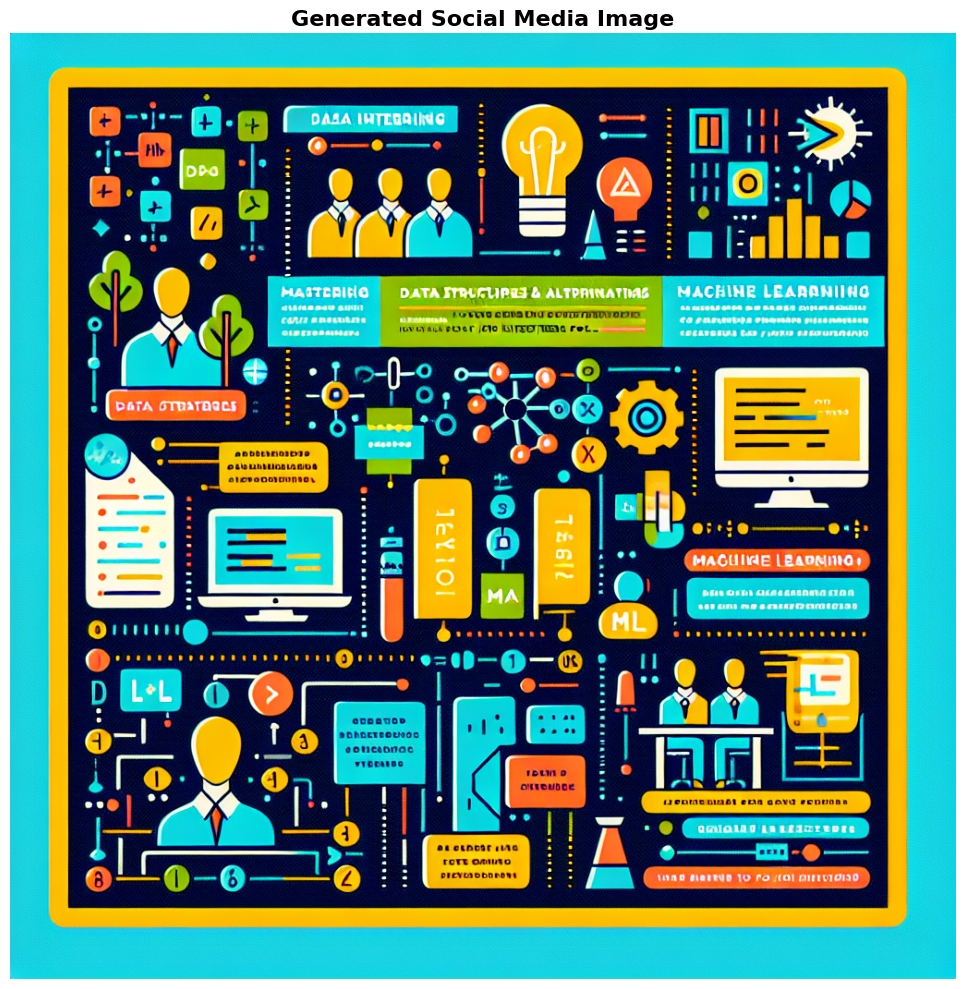

✅ Image Generated and Displayed

📱 STEP 5: Optimizing for Different Platforms...
SocialMediaPostGenerator (to PlatformOptimizer):

Optimize this complete social media post for different platforms:

STRATEGY:
TARGET_AUDIENCE: College students majoring in computer science, information technology, or related fields, who are in their final year or penultimate year and are actively preparing for campus placements or internships. This audience likely has an interest in software development, data science, and machine learning, and experiences pain points such as anxiety over job readiness, uncertainty about which skills to prioritize, and time management challenges in balancing coursework with placement preparation.

POST_TYPE: Inspirational/Educational

TONE: Motivational, encouraging, and slightly authoritative to convey the importance of the message.

KEY_MESSAGE: Mastering DSA (Data Structures and Algorithms) and ML (Machine Learning) can significantly boost your confidence and prospects 

In [14]:
generator = create_social_media_post("motivate students sitting for placements to practice dsa and ml topics properly")


🎬 Generating social media post for: 'how do you save money and invest in your 20s and why is it so important?'
User (to SocialMediaPostGenerator):

how do you save money and invest in your 20s and why is it so important?

--------------------------------------------------------------------------------
🚀 Starting Social Media Post Generation...
📝 Request: how do you save money and invest in your 20s and why is it so important?

🎯 STEP 1: Creating Content Strategy...
SocialMediaPostGenerator (to ContentStrategist):

how do you save money and invest in your 20s and why is it so important?

--------------------------------------------------------------------------------
ContentStrategist (to SocialMediaPostGenerator):

TARGET_AUDIENCE: Young adults aged 20-29, early in their career, possibly recent college graduates, beginning to navigate personal finance and investment. They are interested in building a strong financial foundation but might feel overwhelmed by the vast amount of informati

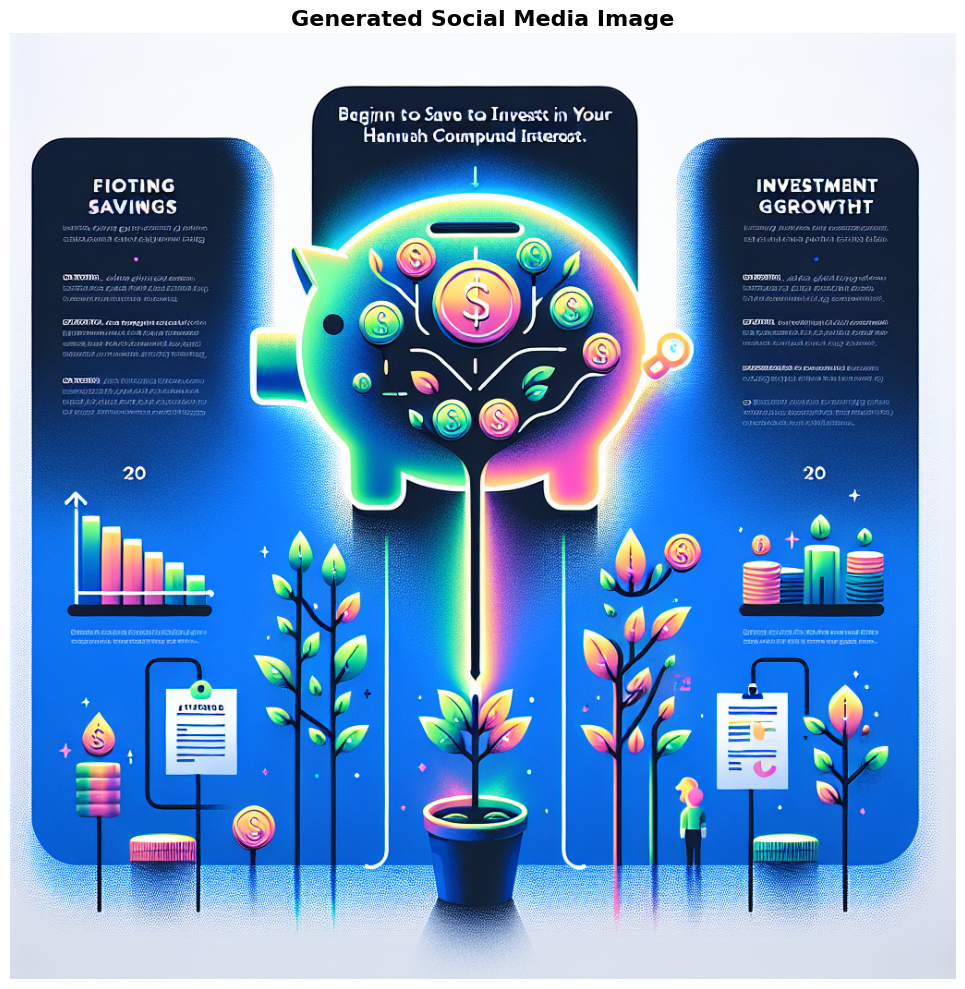

✅ Image Generated and Displayed

📱 STEP 5: Optimizing for Different Platforms...
SocialMediaPostGenerator (to PlatformOptimizer):

Optimize this complete social media post for different platforms:

STRATEGY:
TARGET_AUDIENCE: Young adults aged 20-29, early in their career, possibly recent college graduates, beginning to navigate personal finance and investment. They are interested in building a strong financial foundation but might feel overwhelmed by the vast amount of information out there. They likely have an interest in improving their financial literacy and are looking for practical, actionable advice.

POST_TYPE: Educational

TONE: Inspirational, friendly, authoritative

KEY_MESSAGE: Starting to save and invest in your 20s sets the foundation for a secure financial future and leverages the power of compound interest.

VISUAL_STYLE: Modern, with a minimalist infographic layout that breaks down complex information into digestible, easy-to-understand steps. Bright, engaging colors to

In [4]:
generator = create_social_media_post("how do you save money and invest in your 20s and why is it so important?")
